# K-Select notbook
This notebook conducts 2 parts:
1. K-Select algorithm.
2. Analysis of k across cities and years. 

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from shapely import wkt

## K-Select algorithm.

In [33]:
# Extract the strongly connected components and print.

# Load your numpy array and node to CBG mapping
flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_3.npy')

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Create directed graph from flow matrix
G = nx.from_numpy_matrix(flow_matrix, create_using=nx.DiGraph)

# Find all strongly connected components
scc = list(nx.strongly_connected_components(G))

# Print the strongly connected components
for i, component in enumerate(scc, start=1):
    print(f"Strongly connected component {i}: {component}")


Strongly connected component 1: {773}
Strongly connected component 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

In [11]:
# The algorithm to find the smallest k such that the subgraph remains strongly connected
# The binary search algorithm is used in finding the smallest k
# Input: flow_matrix: numpy array of flow matrix
# Output: k: the smallest k such that the subgraph remains strongly connected

import numpy as np
import networkx as nx
import pandas as pd

def minimum_flows_for_strongly_connectivity(flow_matrix):
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_matrix(flow_matrix, create_using=nx.DiGraph)

    # Find all strongly connected components
    scc = list(nx.strongly_connected_components(G))

    # Create a subgraph with only nodes in the first SCC
    sub_G = G.subgraph(max(scc, key=len))
    print("nodes of the largest strongly connected graph for city:", len(sub_G.nodes()))
    num_units = len(sub_G.nodes())

    # Function to check if the graph is strongly connected when only top k edges are kept for each node
    def check_strongly_connected_k(graph, k):
        # Create a new graph which only keeps top k outgoing edges for each node
        new_graph = nx.DiGraph()
        for node in graph.nodes():
            edges = sorted(graph.out_edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)[:k]
            new_graph.add_edges_from(edges)
        # Check if the new graph is still strongly connected
        return nx.is_strongly_connected(new_graph)

    """# Determine the smallest value of k such that the graph remains strongly connected
    k = 1
    while not check_strongly_connected_k(sub_G, k):
        k += 1
    return k """

    # Binary search variables
    low = 1
    high = num_units

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is weakly connected for the current mid
        if check_strongly_connected_k(sub_G, mid):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is weakly connected for the low/high point
    if  check_strongly_connected_k(sub_G, low):
        return low
    else:
        return -1

# one month example
"""# Load your numpy array
flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_7.npy')
k=minimum_flows_for_strongly_connectivity(flow_matrix)
print(f"The smallest k such that the subgraph remains strongly connected is {k}.")
"""

'# Load your numpy array\nflow_matrix = np.load(r\'data\\Mobility\\cbg_visit_2022-02_7.npy\')\nk=minimum_flows_for_strongly_connectivity(flow_matrix)\nprint(f"The smallest k such that the subgraph remains strongly connected is {k}.")\n'

In [ ]:
# Plot the map of the the share of the top-k flows in the total flows of each CBG

# Load your numpy array and node to CBG mapping
flow_matrix = np.load('path_to_your_file.npy')
with open('id_dict_{city_id}.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Basic_Geographic_Statistics_CBG.csv')

# Convert the WKT boundary strings into shapely objects
df['Boundary'] = df['Boundary'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='Boundary')

# Calculate the share of the top k flows from each CBG of the total flow from each CBG
flow_sum = flow_matrix.sum(axis=1)
flow_top_k_sum = np.sort(flow_matrix, axis=1)[:, -k:].sum(axis=1)
flow_share = flow_top_k_sum / flow_sum

# Create a mapping from CBG code to flow share
flow_share_dict = {id_dict[i]: flow_share[i] for i in range(flow_matrix.shape[0])}

# Map the flow share values to the CBGs in the GeoDataFrame
gdf['Flow Share'] = gdf['CBG Code'].map(flow_share_dict)

# Plot the map, coloring the CBGs based on the flow share
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(column='Flow Share', ax=ax, legend=True, cmap='coolwarm')

# Set the title
plt.title('Flow Share by CBG')

# Save the plot
plt.savefig('flow_share_map.png', dpi=300)


In [ ]:
# Calculating entropy of outflows for each CBG
import numpy as np
from scipy.stats import entropy

# Normalize the flow matrix so that each row sums to 1
flow_matrix_normalized = flow_matrix / flow_matrix.sum(axis=1, keepdims=True)

# Compute the entropy of each row of the flow matrix
# Note that scipy's entropy function computes the natural logarithm, so to get base 2 logarithms, we set the base parameter to 2
entropies = entropy(flow_matrix_normalized.T, base=2)

# Create a mapping from CBG code to entropy
entropy_dict = {id_dict[i]: entropies[i] for i in range(flow_matrix.shape[0])}

# Map the entropy values to the CBGs in the GeoDataFrame
gdf['Entropy'] = gdf['CBG Code'].map(entropy_dict)

# Plot the map, coloring the CBGs based on the entropy
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(column='Entropy', ax=ax, legend=True, cmap='viridis')

# Set the title
plt.title('Entropy by CBG')

# Save the plot
plt.savefig('entropy_map.png', dpi=300)



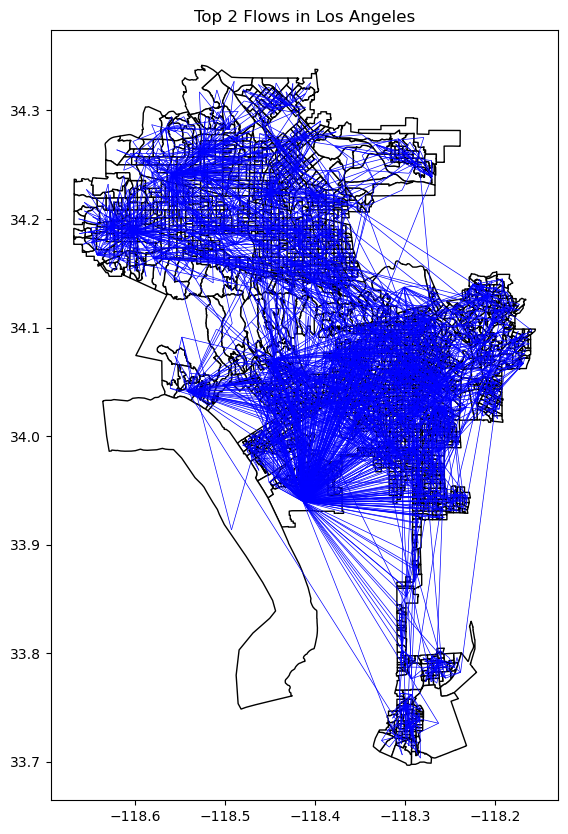

In [17]:
# Draw a flowmap for top-k network

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import networkx as nx
import pickle
from matplotlib.collections import LineCollection


# Load your numpy array and node to CBG mapping
flow_matrix = np.load(r'data\Mobility\cbg_visit_2022-02_2.npy')

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Load the id_dict_2.pkl
with open(r'data\Mobility\id_dict_2.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_of_cities\Los_Angeles_city.shp")

# Convert the WKT centroid strings into shapely Point objects
gdf['Centroid'] = gdf['Centroid'].apply(wkt.loads)

# Define function to create graph for given k
def create_graph(k):
    sorted_indices = np.argsort(-flow_matrix, axis=1)
    edges = [(i, j) for i in range(flow_matrix.shape[0]) for j in sorted_indices[i, :k]]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G,edges

# Create all flows graph
#all_flows_graph = create_graph(flow_matrix.shape[0])

# Create top k flows graph
top_k_flows_G, top_k_flows_graph = create_graph(2)

# Define function to plot flow map
def plot_flow_map(G, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    pos = {node: (gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].y) for node in G.nodes()}
    nx.draw_networkx(G, pos, with_labels=False, node_size=10, ax=ax)

    plt.title(title)
    plt.show()

def plot_flow_map2(graph, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    # Create lines for each flow
    lines = [([gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].y], 
               [gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].y]) 
              for i, j in graph]

    lc = LineCollection(lines, color='blue', linewidths=0.5)

    # Add lines to plot
    ax.add_collection(lc)

    plt.title(title)
    plt.show()

# Plot all flows map
#plot_flow_map(all_flows_graph, 'All Flows in Los Angeles')

# Plot top k flows map
plot_flow_map2(top_k_flows_graph, f'Top {2} Flows in Los Angeles')


In [ ]:

# Calculate the minimum k for strongly connectivity for each city-month and record them.
k_table = pd.DataFrame(columns=['year','month'])
for i in range(1, 11):
    k_table[i] = -100

k_table.set_index(['year', 'month'], inplace=True)

for year in range(2019, 2023):
    for month in range(1, 13):
        for city in range(1, 11):
            if os.path.exists(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city)) == False:
                print("No data for {year_}-{month_}_{city_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city))
                continue
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            k = minimum_flows_for_strongly_connectivity(flow_matrix)
            #print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))
            k_table.loc[(year,month),city] = k
k_table.to_csv("all_k.csv")

In [ ]:
# Calculate total flows of one year for each cities.
# And then calculate the minimum flow for strongly connectivity.

def cal_total_flow(year, city):
    """_summary_

    Args:
        year (_type_): _description_
        city (_type_): _description_

    Returns:
        _type_: _description_
    """    
    # Define the file name pattern and the months
    filename_pattern = r"data\Mobility\cbg_visit_{year}-{month}_{city}.npy"

    months = range(1,13)
    # Initialize an empty array to hold the total flow
    total_flow = None

    # Load each file and add it to the total flow
    for month in months:
        file_name = filename_pattern.format(month = str(month).zfill(2), year = year, city = city)
        if os.path.exists(file_name):
            monthly_flow = np.load(file_name)
            if total_flow is None:
                total_flow = monthly_flow
            else:
                total_flow += monthly_flow
        else:
            print("no file of {}".format(file_name))
    return total_flow
# Now `total_flow` holds the sum of all the monthly flows
k_table = pd.DataFrame(columns=['year'])
for i in range(1, 11):
    k_table[i] = -100

k_table.set_index(['year'], inplace=True)


for year in range(2018, 2023):
    for city in range(1, 11):
        flow_matrix = cal_total_flow(year, city)
        k = minimum_flows_for_strongly_connectivity(flow_matrix)
        #print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))
        k_table.loc[year,city] = k
k_table.to_csv("all_k_yearly.csv")

In [8]:
def draw_k_box(df, cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583], year = "", save = False):
    fig, ax1 = plt.subplots()

    # 画箱线图
    green = (30/255, 134/255, 51/255)
    blue = (25/255,97/255,147/255)
    red = (201/255,	0/255,	42/255	)
    boxprops = dict(color=blue)
    medianprops = dict(color=green)
    whiskerprops = dict(color='Black')
    
    #df.boxplot(ax=ax1, boxprops=boxprops, medianprops=medianprops,whiskerprops=whiskerprops)
    df.boxplot(ax=ax1)
    ax1.set_yticks(np.arange(0, 1601, 200))
    ax1.set_ylabel('k Values')
    plt.xticks(rotation=45)
    
    # 创建第二个 y 轴
    ax2 = ax1.twinx()

    # 设置x轴为df的columns
    x = np.array(range(len(df.columns)))

    ax2.plot(x+1, cbg_counts, color='r', label='CBG Counts')
    ax2.set_ylabel('CBG Counts')

    # 添加图例
    ax2.legend(loc="upper right")

    plt.title("k's boxplots and CBG counts from 2018 to 2022".format(year) )
    plt.tight_layout()
    if year == "all":
        plt.savefig("k's boxplot and CBG counts from 2018 to 2022.png", dpi=300)

    else:
        plt.savefig("k's boxplot and CBG counts in year {}.png".format(year), dpi=300)
    plt.show()


/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_year.drop(['year', 'month'], axis=1, inplace=True)
/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_year.drop(['year', 'month'], axis=1, inplace=True)
/var/folders/lx/48nrsg4n38b36nwmsqwzzqxh0000gn/T/ipykernel_31613/1741706520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

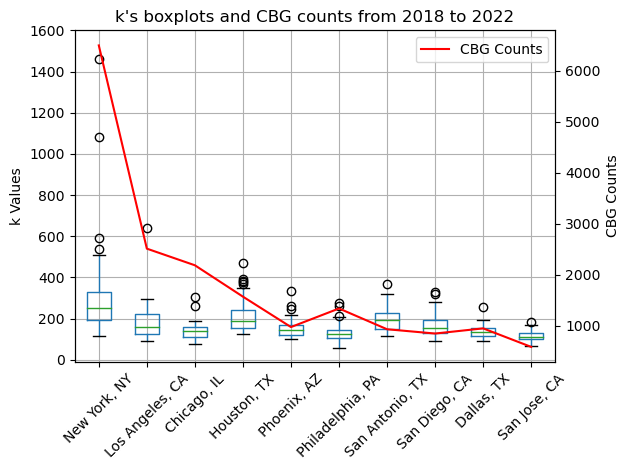

In [9]:
import matplotlib.pyplot as plt

df = pd.read_csv(r"all_k.csv")
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

df.columns = ['year', 'month']+cities
for year in range(2018,2022):
#year = 2020
    # 选择2018年的数据
    df_single_year = df[df["year"] == year]
    df_single_year.drop(['year', 'month'], axis=1, inplace=True)
    #draw_k_box(df_single_year, year = year, save = True)

df.drop(['year', 'month'], axis=1, inplace=True)
draw_k_box(df, year = "all", save = True)

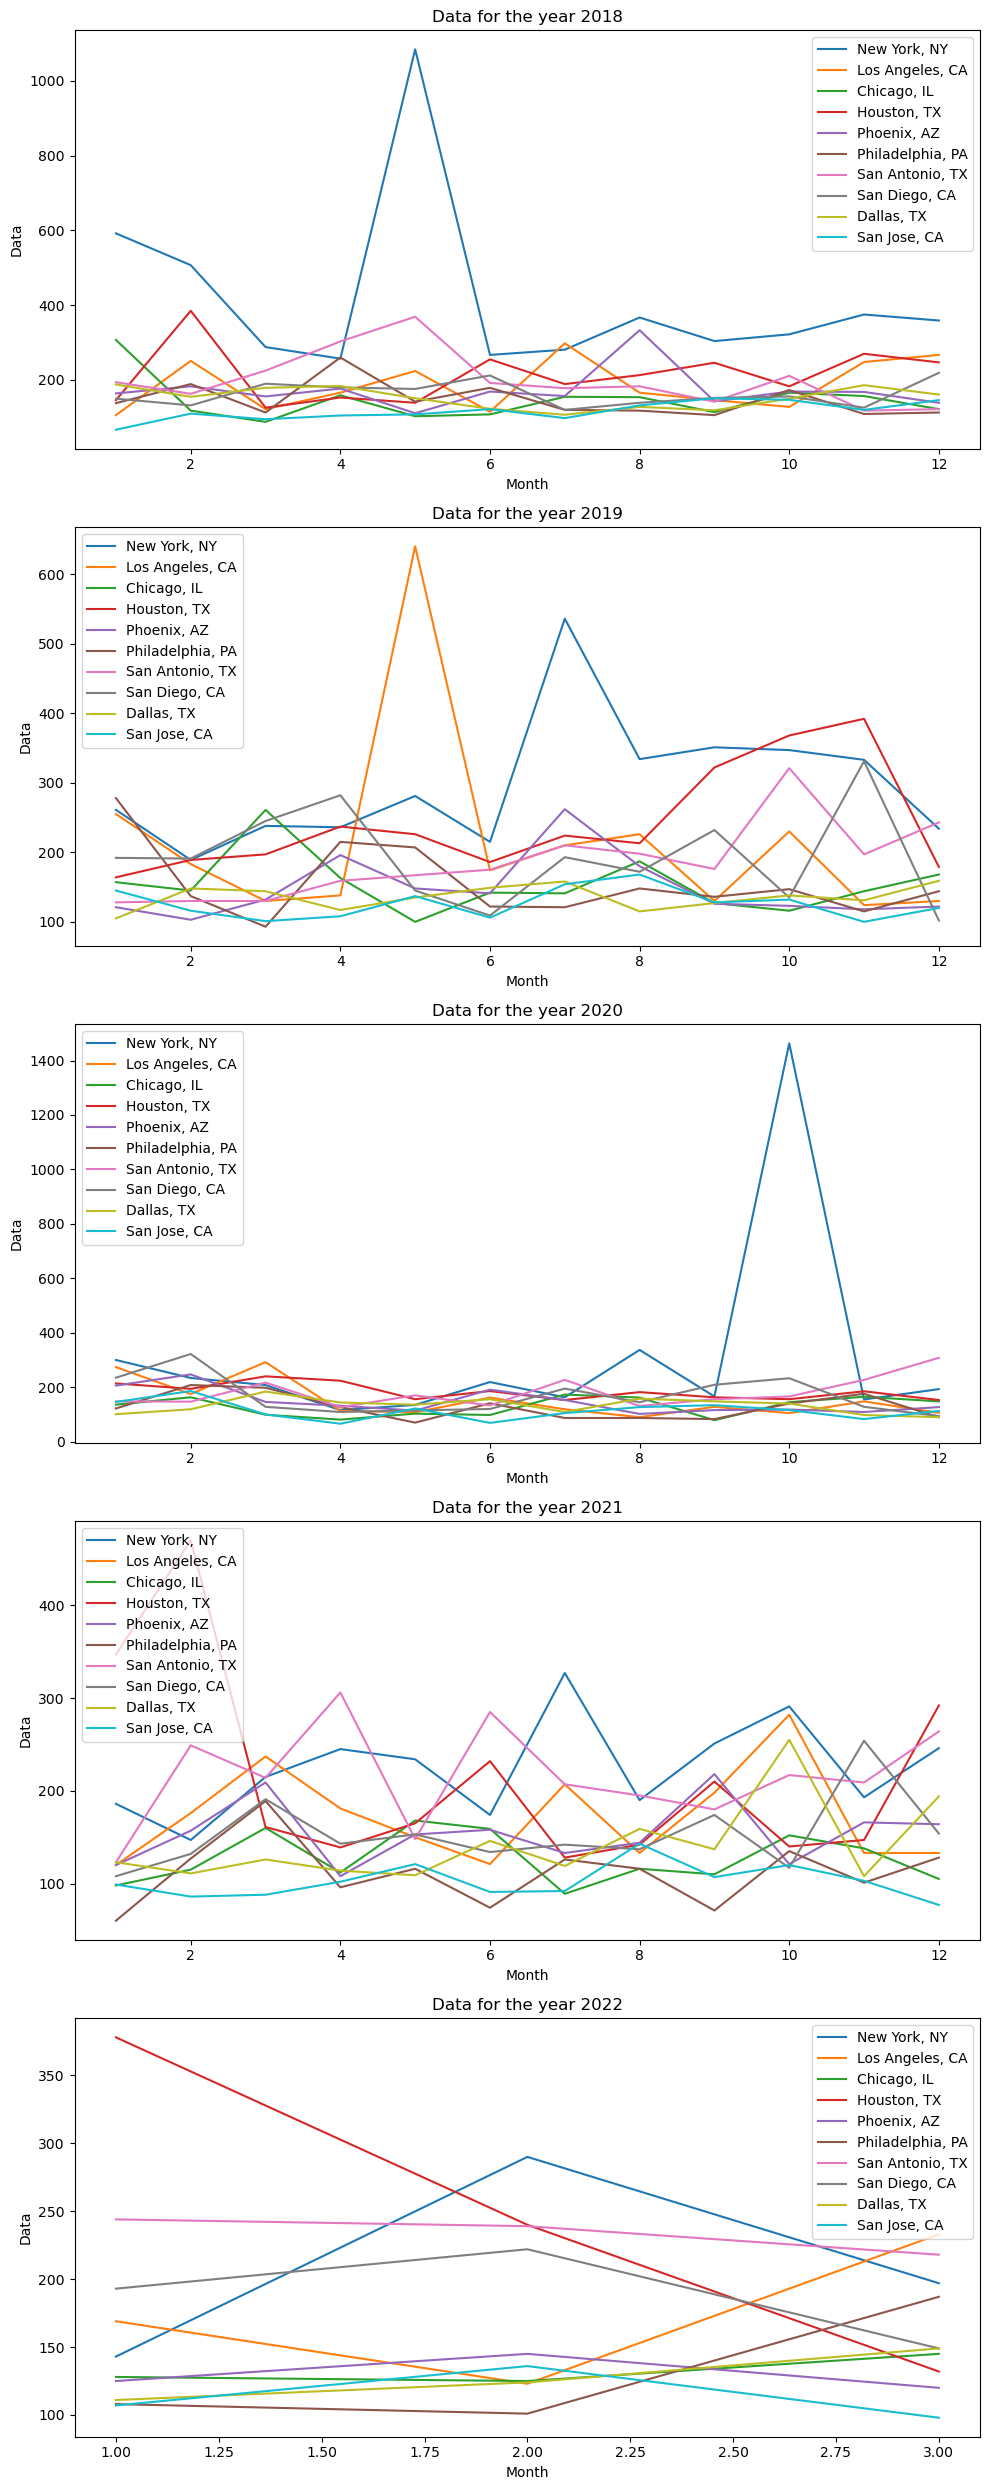

In [4]:
import matplotlib.pyplot as plt

# 将 'year' 和 'month' 设为索引
df.set_index(['year', 'month'], inplace=True)

# 获取年份列表
years = df.index.get_level_values('year').unique()
city_list = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
# 创建一个图形
fig, axs = plt.subplots(len(years), 1, figsize=(10, 5*len(years)))

# 为每个年份绘制一条折线
for ax, year in zip(axs, years):
    # 获取该年份的数据
    df_year = df.xs(year, level='year')
    
    # 对每个城市进行绘制
    for city in city_list:
        ax.plot(df_year.index, df_year[city], label=city)

    # 设置标题、轴标签等
    ax.set_title(f'Data for the year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Data')
    ax.legend()

plt.tight_layout()
plt.show()


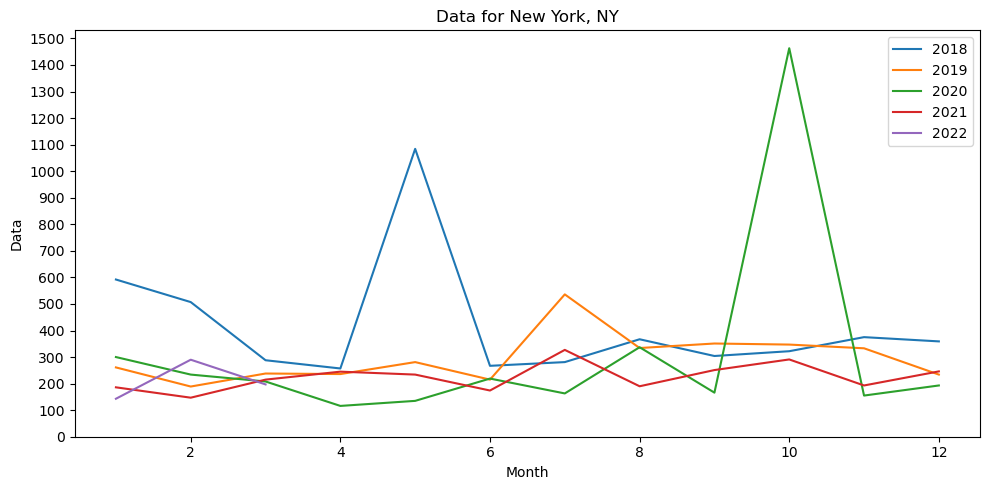

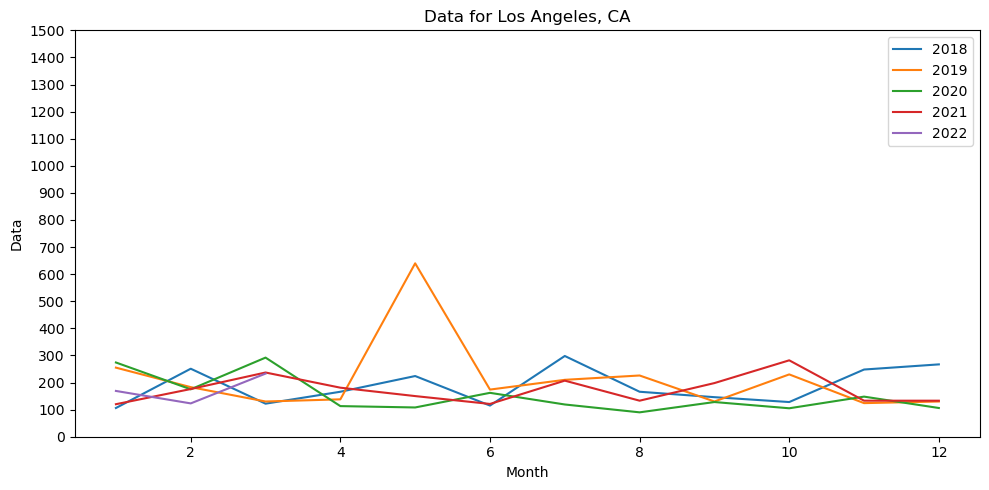

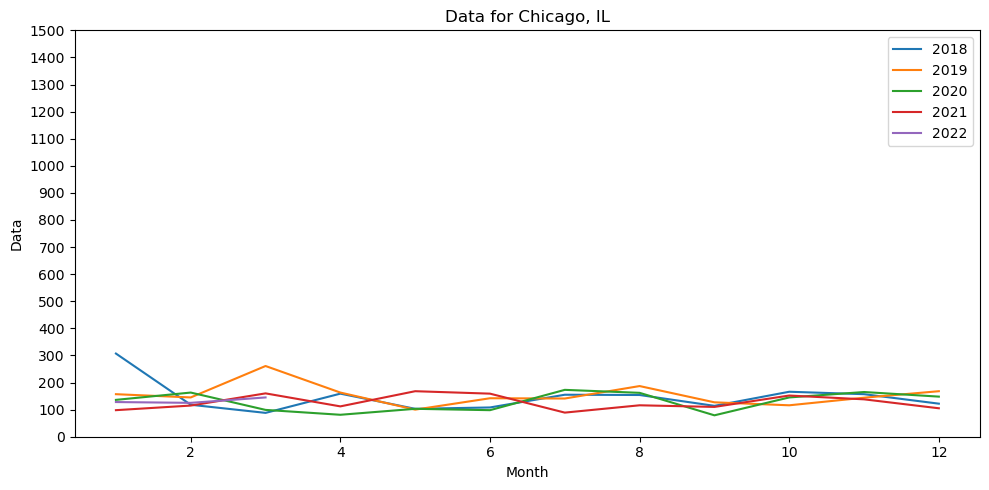

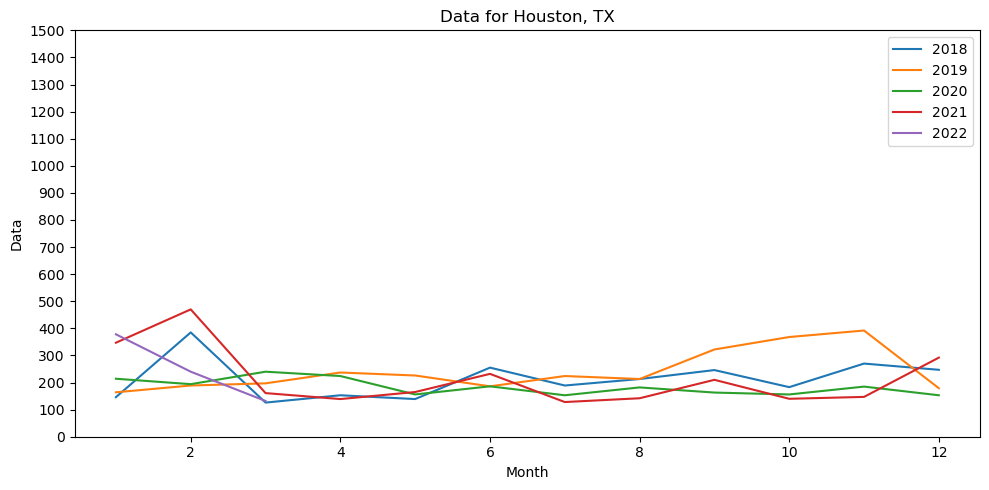

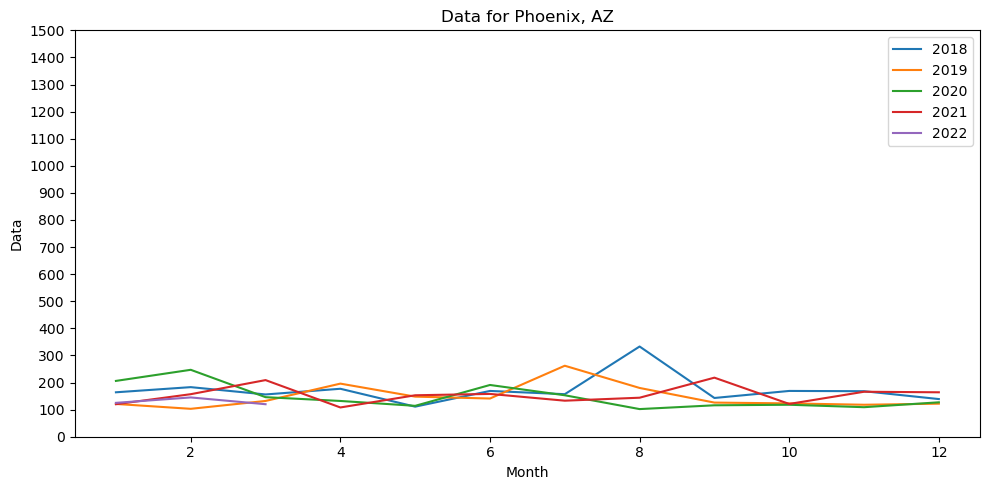

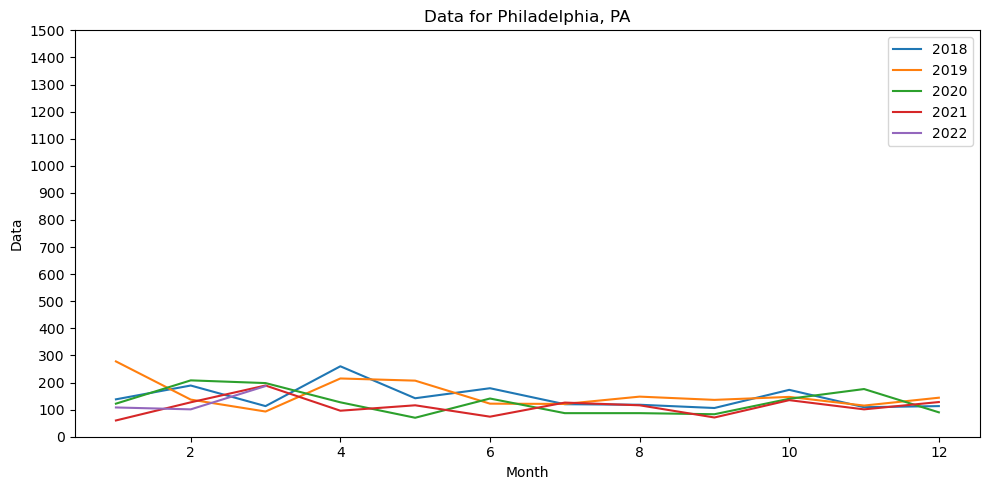

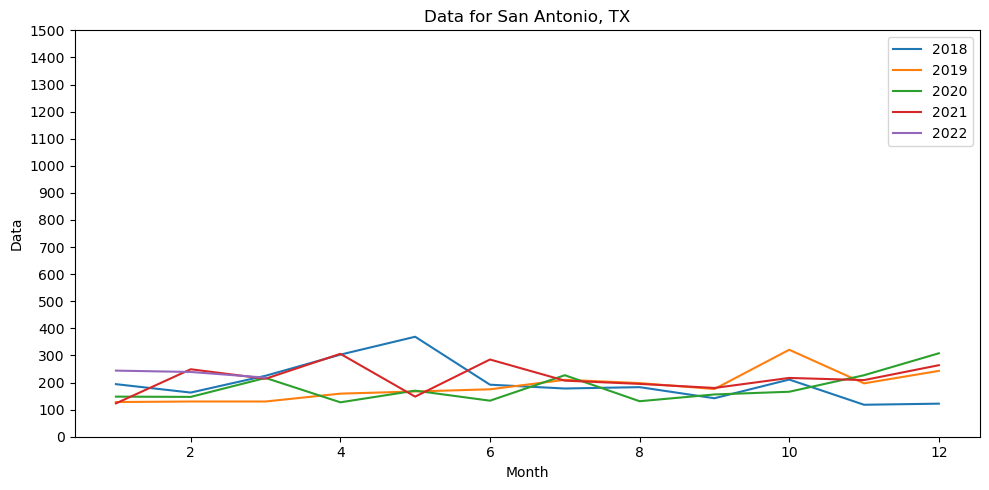

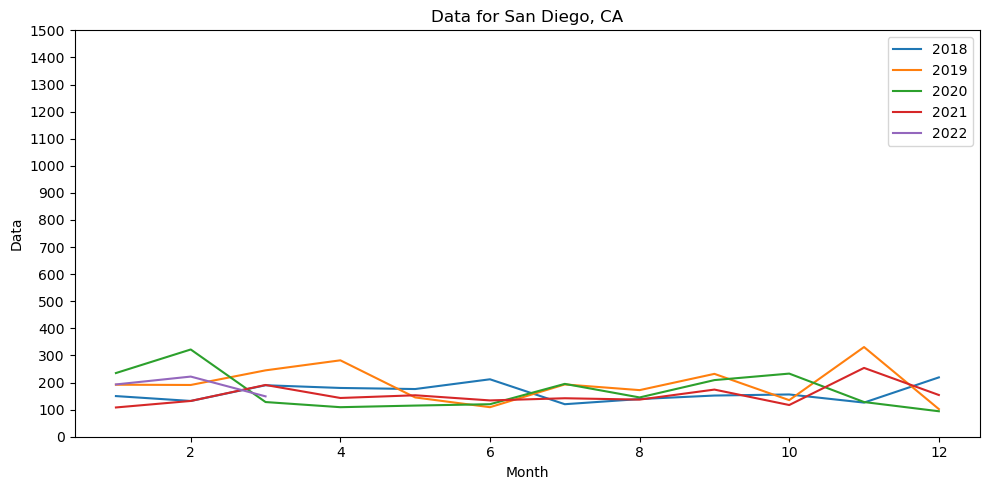

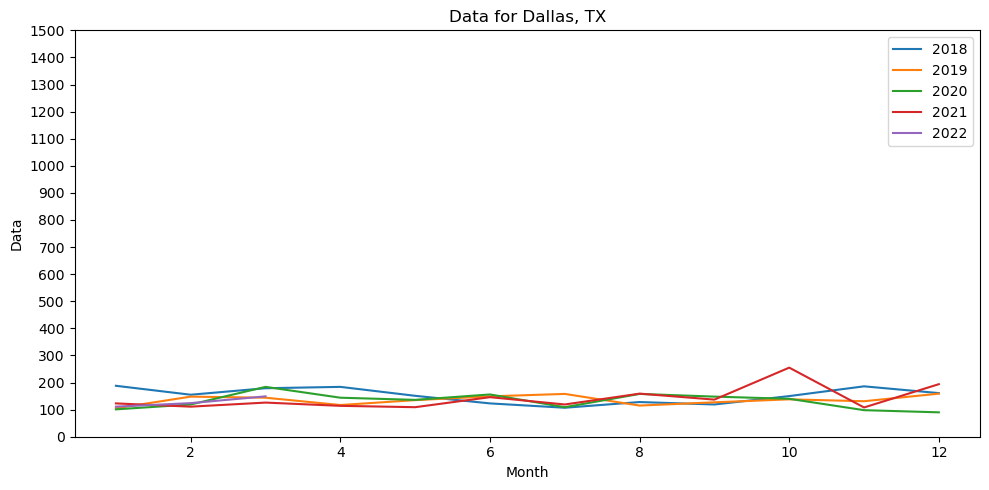

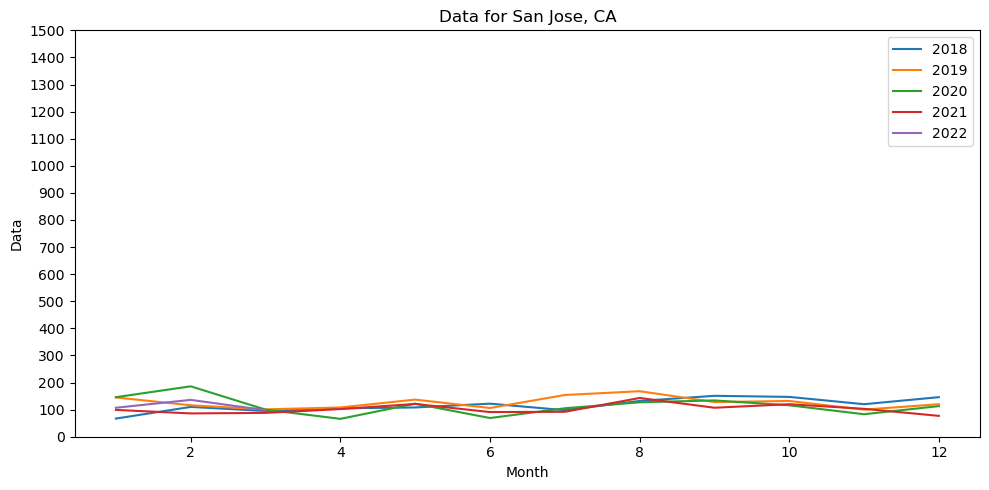

In [8]:
import matplotlib.pyplot as plt

# 获取年份列表
years = df.index.get_level_values('year').unique()

# 对每个城市进行绘制
for city in city_list:
    # 创建一个图形
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # 为每个年份绘制一条折线
    for year in years:
        # 获取该年份的数据
        df_year = df.xs(year, level='year')

        # 绘制折线
        ax.plot(df_year.index, df_year[city], label=str(year))

    # 设置标题、轴标签等
    ax.set_title(f'Data for {city}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Data')
    ax.legend()
    ax.set_yticks(np.arange(0, 1600, 100))
    plt.tight_layout()
    plt.show()


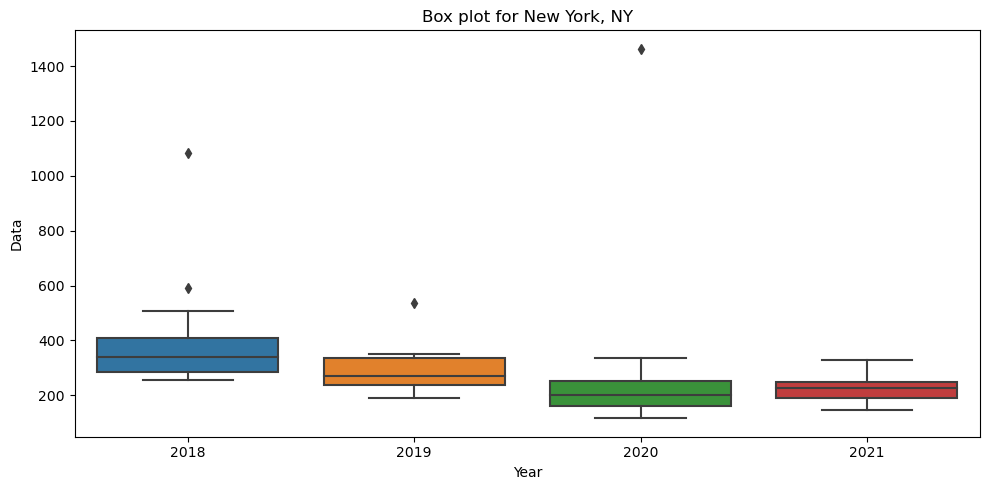

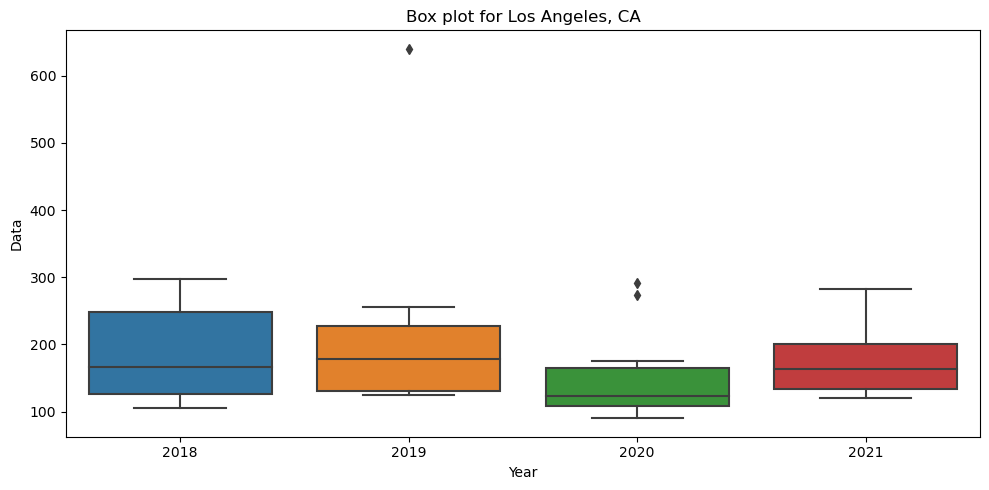

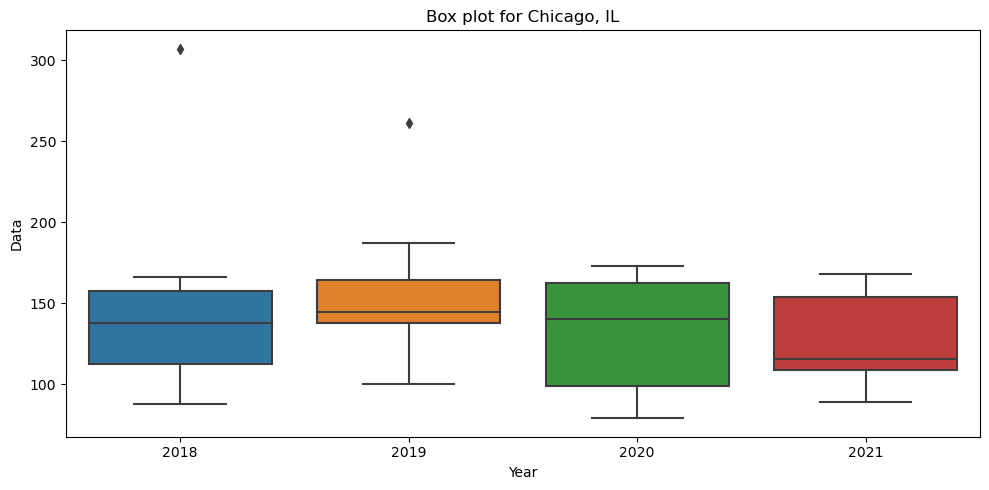

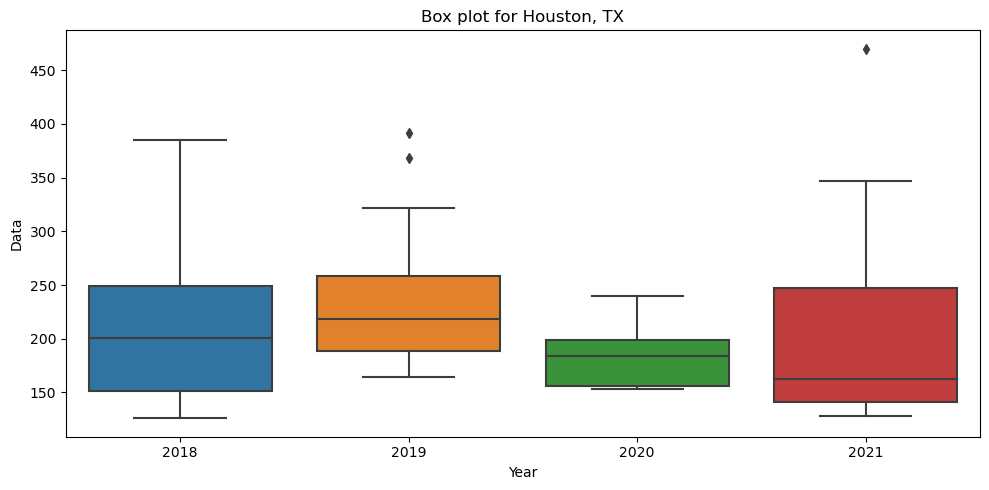

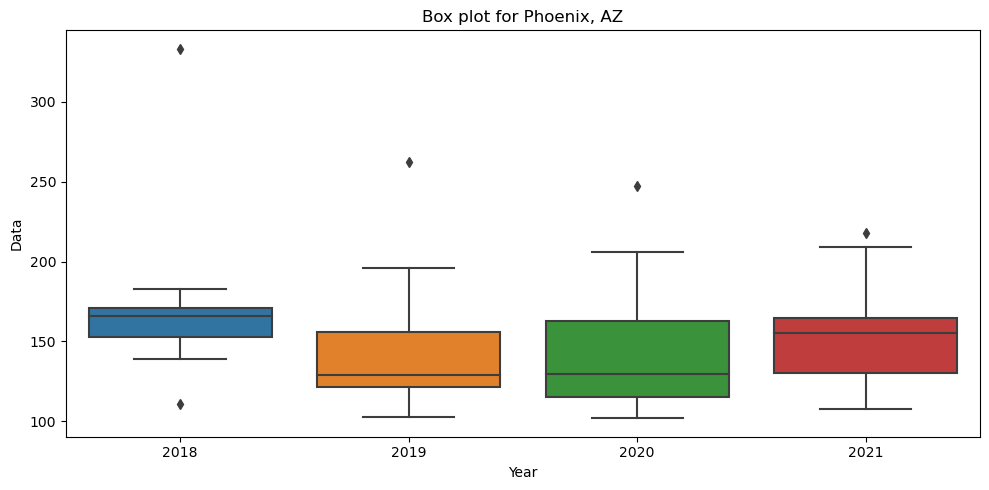

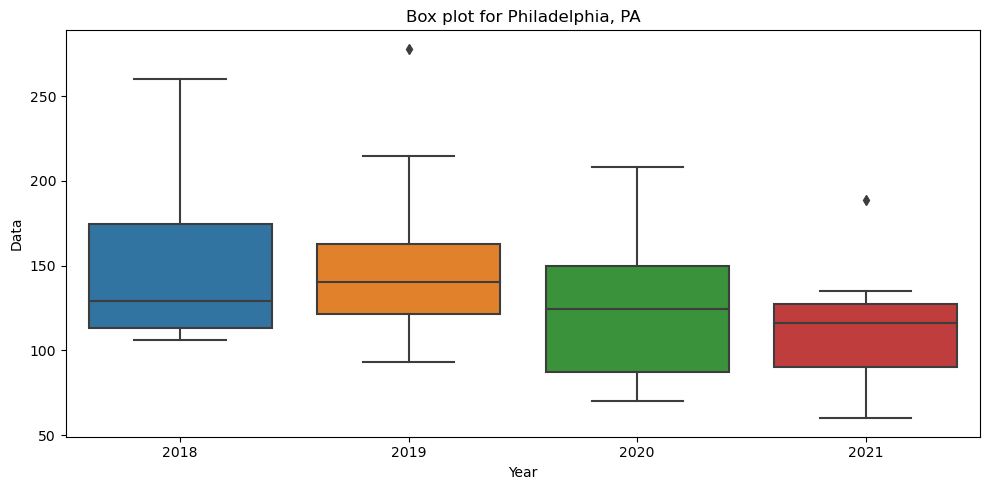

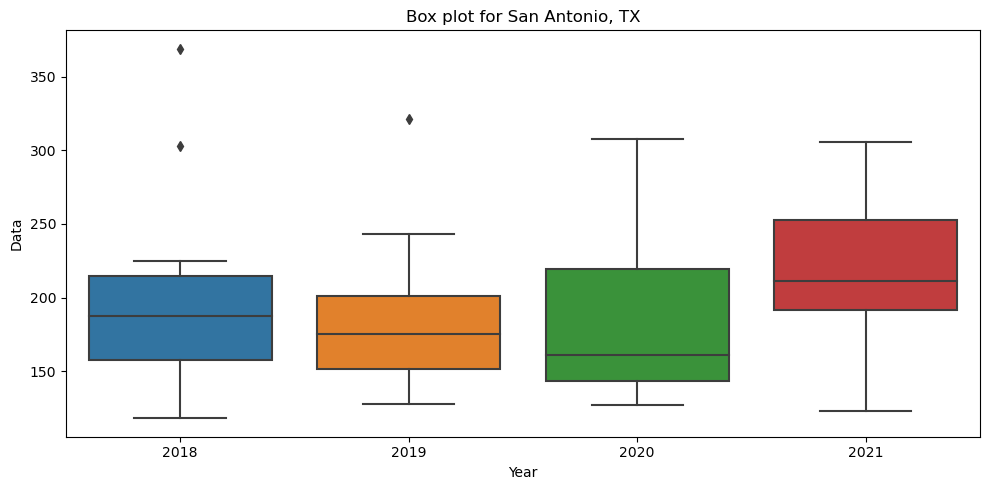

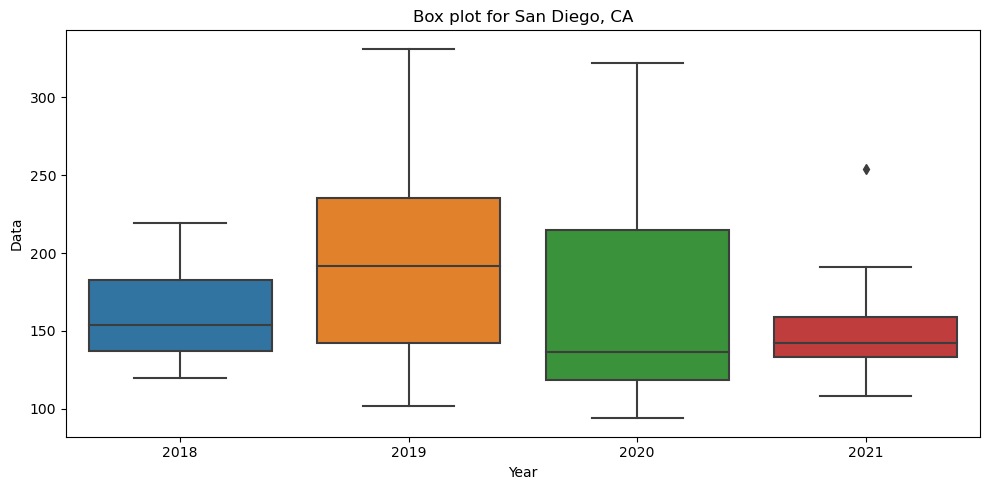

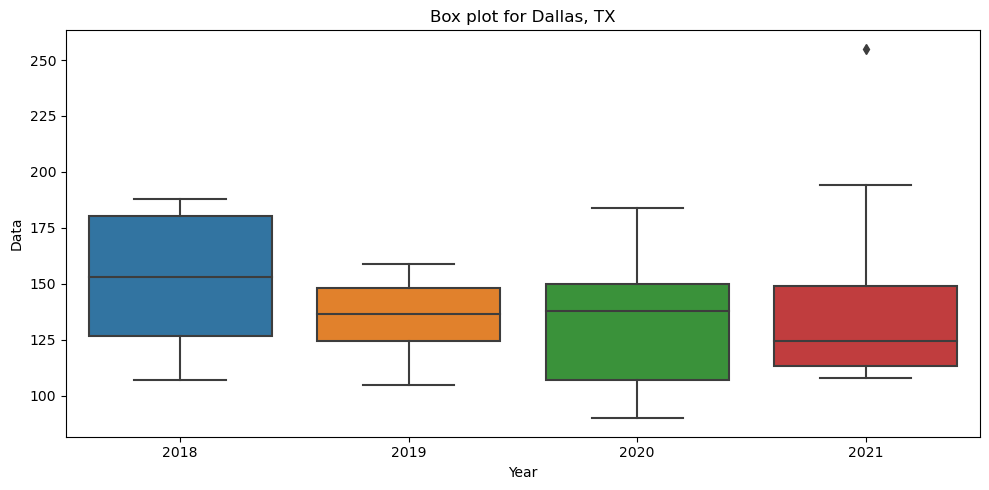

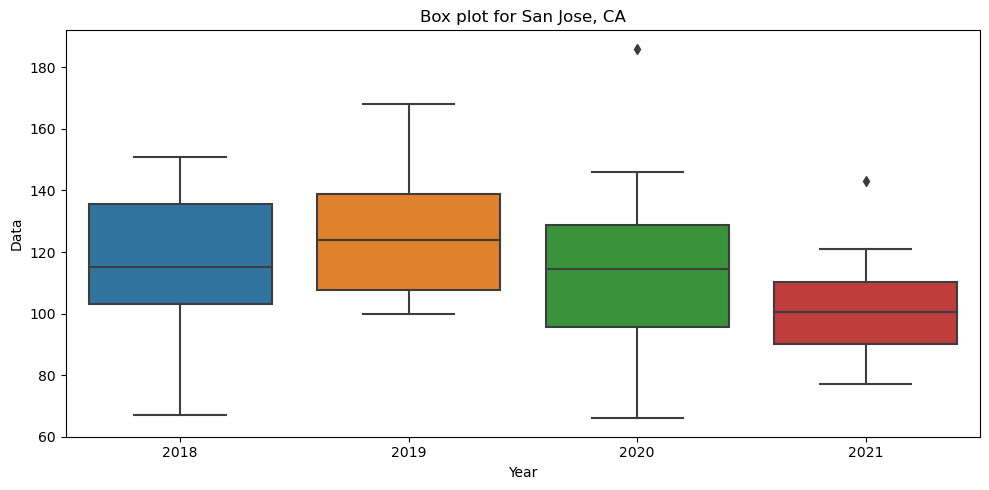

In [11]:
import seaborn as sns
# 删除 2022 年的数据
df = df[df.index.get_level_values('year') != 2022]

# 对每个城市进行绘制
for city in city_list:
    # 创建一个图形
    fig, ax = plt.subplots(figsize=(10, 5))

    # 创建一个新的数据框，其中包含年份和城市的数据
    df_city = df[city].reset_index()

    # 使用 seaborn 创建箱线图
    sns.boxplot(x='year', y=city, data=df_city, ax=ax)

    # 设置标题、轴标签等
    ax.set_title(f'Box plot for {city}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Data')

    plt.tight_layout()
    plt.show()


In [ ]:
# Draw flowmaps, in whcih strongly connected components are colored differently.
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import networkx as nx
import pickle
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.neighbors import kneighbors_graph
from matplotlib.cm import get_cmap

# Load your numpy array and node to CBG mapping
flow_matrix = np.load(r'data\Mobility\cbg_visit_2020-10_1.npy')

# Set the diagonal elements to zero
np.fill_diagonal(flow_matrix, 0)

# Load the id_dict_2.pkl
with open(r'data\Mobility\id_dict_1.pkl', 'rb') as f:
    id_dict = pickle.load(f)

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_of_cities\New_York_city.shp")
# Convert the WKT centroid strings into shapely Point objects
gdf['Centroid'] = gdf['Centroid'].apply(wkt.loads)

# Define function to create graph for given k
def create_graph(k):
    sorted_indices = np.argsort(-flow_matrix, axis=1)
    edges = [(i, j) for i in range(flow_matrix.shape[0]) for j in sorted_indices[i, :k]]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G,edges


# Define function to plot flow map
def plot_flow_map(G, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')
    #nx.draw_networkx(G, pos, with_labels=False, node_size=10, ax=ax)

    pos = {node: (gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[node], 'Centroid'].values[0].y) for node in G.nodes()}


    # 计算连通子图
    scc = list(nx.strongly_connected_components(G))
    print(len(scc))
    # 绘制网络
    cmap = get_cmap('viridis')

    for i, component in enumerate(scc):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_color=cmap(i / len(scc)), ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u in component for v in G.neighbors(u)], ax=ax)
    
    plt.title(title)
    plt.show()

def plot_flow_map2(graph, title):
    fig, ax = plt.subplots(figsize=(10,10))

    # Plot base map
    gdf.plot(ax=ax, color='white', edgecolor='black')

    # Create lines for each flow
    lines = [([gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[i], 'Centroid'].values[0].y], 
               [gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].x, gdf.loc[gdf['CBG_Code'] == id_dict[j], 'Centroid'].values[0].y]) 
              for i, j in graph]

    lc = LineCollection(lines, color='blue', linewidths=0.5)

    # Add lines to plot
    ax.add_collection(lc)

    plt.title(title)
    plt.show()
    
    
# 指定 k 值
k_values = [160, 250, 337]

for k in k_values:
    top_k_flows_G, top_k_flows_graph = create_graph(k)
    plot_flow_map(top_k_flows_G, f'Top {k} Flows in New York')
# Create all flows graph
#all_flows_graph = create_graph(flow_matrix.shape[0])

# Create top k flows graph

# Plot all flows map
#plot_flow_map(all_flows_graph, 'All Flows in Los Angeles')

# Plot top k flows map
#plot_flow_map(top_k_flows_graph, f'Top {2} Flows in Los Angeles')





In [16]:
# Calculating cbg counts for each city
cbg_counts = []
for year in range(2019, 2020):
    for month in range(1, 2):
        for city in range(1, 11):
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            n = flow_matrix.shape[0]
            cbg_counts.append(n)


In [ ]:
# Abloshed 
# the function to find the minimum number of flows required to ensure connectivity in a network
def minimum_flows_for_connectivity(flow_matrix):
    # Initialize k
    k = 1

    # Get the number of units (assumes flow_matrix is square)
    num_units = flow_matrix.shape[0]
    np.fill_diagonal(flow_matrix, 0)
    # Create a list of indices for sorting the flows in descending order
    sorted_indices = np.argsort(-flow_matrix, axis=1)

    while True:
        # Initialize a directed graph
        G = nx.DiGraph()

        # Add all nodes to the graph
        G.add_nodes_from(range(num_units))

        # For each origin unit, add edges for the top k flows
        for origin in range(num_units):
            for destination in sorted_indices[origin, :k]:
                G.add_edge(origin, destination)

        # Check if the graph is weakly connected
        if nx.is_weakly_connected(G):
            # If it is, return the current value of k
            return k

        # If not, increment k
        k += 1
        
# Use cases of the function
"""flow_matrix = np.load(r'data\Mobility\cbg_visit_2018-01_1.npy')
k = minimum_flows_for_connectivity(flow_matrix)
print(f'The minimum number of highest flows needed to keep the graph weakly connected is {k}.')"""

"""for year in range(2018, 2023):
    for month in range(1, 13):
        for city in range(1, 11):
            flow_matrix = np.load(r'data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_ = year, month_ = str(month).zfill(2), city_ = city))
            k = minimum_flows_for_connectivity(flow_matrix)
            print("{year_}-{month_}_{city_}:{k_}".format(year_ = year, month_ = str(month).zfill(2), city_ = city,k_=k))"""


In [ ]:
# Abloshed 
# Extracting the minimum number of highest flows needed to keep the graph weakly connected using binary search
import numpy as np
import networkx as nx

def binary_search_connectivity(flow_matrix):
    num_units = flow_matrix.shape[0]

    # Sorted indices for descending order of flow for each unit
    sorted_indices = np.argsort(-flow_matrix, axis=1)

    # Binary search variables
    low = 1
    high = num_units 
    
    # Function to create a graph for a given k
    def create_graph(k):
        G = nx.DiGraph()
        G.add_nodes_from(range(num_units))
        for origin in range(num_units):
            for destination in sorted_indices[origin, :k]:
                G.add_edge(origin, destination)
        return G

    while low < high:
        mid = low + (high - low) // 2

        # Check if the graph is weakly connected for the current mid
        if nx.is_weakly_connected(create_graph(mid)):
            high = mid
        else:
            low = mid + 1

    # Final check if the graph is weakly connected for the low/high point
    if nx.is_weakly_connected(create_graph(low)):
        return low
    else:
        return -1

# Usage:
flow_matrix = np.load('path_to_your_file.npy')
k = binary_search_connectivity(flow_matrix)
print(f'The minimum number of highest flows needed to keep the graph weakly connected is {k}.')


In [ ]:
# Grographical data preprocessing (from csv to shp)
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(r'data\Basic_Geographic_Statistics_CBG.csv')

# Convert the WKT boundary strings into shapely objects
df['Boundary'] = df['Boundary'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
# Make sure to specify the correct coordinate system for your data
gdf = gpd.GeoDataFrame(df, geometry='Boundary', crs="EPSG:4326")

# Save the GeoDataFrame as a Shapefile
gdf.to_file("output_file.shp")

In [ ]:
# Geographical data preprocessing (Split whole American CBG data to each city)
import geopandas as gpd

# Load the Shapefile
gdf = gpd.read_file(r"arcgis project\cbgs\cbgs_2018.shp")
print(gdf.info())
# Split the GeoDataFrame into multiple GeoDataFrames based on the 'City Name' column
gdfs = [data for city_name, data in gdf.groupby('City_Name')]

# Save each GeoDataFrame as a separate Shapefile
for city_gdf in gdfs:
    city_name = city_gdf['City_Name'].unique()[0]
    print(city_name)
    # The file name is based on the city name
    # Spaces are replaced with underscores and the file extension .shp is added
    filename = city_name.replace(' ', '_') + '.shp'

    #city_gdf.to_file(r"arcgis project\cbgs\{}",format(filename))
    city_gdf.to_file(filename)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18364 entries, 0 to 18363
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   City_Name   18364 non-null  object  
 1   CBG_Code    18364 non-null  float64 
 2   Year        18364 non-null  float64 
 3   Population  18364 non-null  float64 
 4   Area        18364 non-null  float64 
 5   Centroid    18364 non-null  object  
 6   Shape_Leng  18364 non-null  float64 
 7   Shape_Area  18364 non-null  float64 
 8   geometry    18364 non-null  geometry
dtypes: float64(6), geometry(1), object(2)
memory usage: 1.3+ MB
None
Chicago city
Dallas city
Houston city
Los Angeles city
New York city
Philadelphia city
Phoenix city
San Antonio city
San Diego city
San Jose city
